In [ ]:
!pip install pystan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 66.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.8 MB/s eta 0:00:00


In [ ]:
!pip install hbayesdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 387.7/387.7 kB 9.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 88.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of xarray to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of xarray to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 80.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 111.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB

In [ ]:
import stan
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.optimize import minimize
import nest_asyncio
nest_asyncio.apply()

In [ ]:
def preprocess_data(data):
    """Preprocess data for RLWM model fitting"""
    df_clean = data[(data['choice'] != -1) &
                    (data['key'] != -1) &
                    (data['cor'] != -1) &
                    (data['rew'] != -1) &
                    (data['rt'] > 0.15)]  # Match MATLAB rt threshold
    return df_clean

In [ ]:
def select(pr):
    """Implement random choice selection based on probability distribution"""
    cumsum = np.cumsum(pr)
    return np.searchsorted(cumsum, np.random.random())

In [ ]:
def compute_delay(stimuli, rewards):
    """Compute delay since last correct for each stimulus"""
    delay = np.full_like(stimuli, np.nan, dtype=float)
    for s in np.unique(stimuli):
        T = np.where(stimuli == s)[0]
        for t in T[1:]:
            y = np.where((stimuli[:t] == s) & (rewards[:t] == 1))[0]
            if len(y) > 0:
                delay[t] = t - y[-1]
    return delay

In [ ]:
def compute_pcor(stimuli, rewards):
    """Compute number of previous correct responses"""
    pcor = np.zeros_like(stimuli, dtype=float)
    for s in np.unique(stimuli):
        T = np.where(stimuli == s)[0]
        pcor[T] = np.cumsum(rewards[T]) - rewards[T]
    return pcor

In [ ]:
# Parameter transformation functions
def constrain(params):
    """Convert unconstrained to constrained parameters"""
    return {
        'alpha': 1/(1 + np.exp(-params[0])),  # Logit transform
        'beta': np.exp(params[1])             # Exp transform
    }

def unconstrained_objective(x, data, rl_sm):
    """Objective function for fmin"""
    try:
        constrained_params = constrain(x)
        return -rl_sm.log_prob(constrained_params, data=data)
    except:
        return np.inf

In [ ]:
# Compile the RL model
rl2_model = """
data {
  int<lower=1> N;
  int<lower=1> S;
  int<lower=1> A;
  array[N] int<lower=1, upper=S> stimuli;
  array[N] int<lower=1, upper=A> actions;
  array[N] int<lower=0, upper=1> rewards;
}
parameters {
  real<lower=0, upper=1> alpha;
  real<lower=0> beta;
}
model {
  array[S] vector[A] Q;
  alpha ~ normal(0.4,0.1);
  beta ~ normal(8,2);

  for (s in 1:S) {
    Q[s] = rep_vector(0.0, A);
  }

  for (t in 1:N) {
    int s = stimuli[t];
    int a = actions[t];

    actions[t] ~ categorical_logit(beta * Q[s]);

    Q[s, a] = Q[s, a] + alpha * (rewards[t] - Q[s, a]);
  }
}
"""

In [ ]:
import arviz as az
import matplotlib.pyplot as plt


def plot_mcmc_convergence(fit_object, var_names=['alpha', 'beta'], subject_id=None, block_id=None):
    """
    Generates MCMC trace plots matching the example image style.

    Args:
        fit_object: The fit object returned by compiled_model.sample().
        var_names (list, optional): List of parameter names to plot/summarize.
                                    Defaults to ['alpha', 'beta'].
        subject_id (optional): Identifier for the subject for plot titles.
        block_id (optional): Identifier for the block for plot titles.
    """
    if fit_object is None:
        print("Cannot plot convergence: fit_object is None.")
        return

    # Convert to InferenceData if not already
    if not isinstance(fit_object, az.InferenceData):
        try:
            fit_object = az.convert_to_inference_data(fit_object)
        except Exception as e:
            print(f"Error converting to InferenceData: {e}")
            return

    # Create figure with subplots - one for each parameter
    n_params = len(var_names)
    fig, axes = plt.subplots(1, n_params, figsize=(4*n_params, 4), sharey=False)

    # Handle single parameter case
    if n_params == 1:
        axes = [axes]

    # Define chain colors matching the example image
    chain_colors = ['#FF7F0E', '#9467BD', '#4C2889', '#DBAF57']  # orange, purple, dark purple, light brown

    # Plot each parameter
    for i, var_name in enumerate(var_names):
        if var_name not in fit_object.posterior:
            print(f"Warning: Parameter '{var_name}' not found in fit object.")
            axes[i].text(0.5, 0.5, f"Parameter '{var_name}' not found",
                        ha='center', transform=axes[i].transAxes)
            continue

        # Get parameter data
        param_data = fit_object.posterior[var_name]

        # Handle multidimensional parameters if needed
        if len(param_data.dims) > 2:
            # For multidimensional params, just plot the first element
            if 'chain' in param_data.dims and 'draw' in param_data.dims:
                flat_dims = [d for d in param_data.dims if d not in ['chain', 'draw']]
                if flat_dims:
                    idx = {dim: 0 for dim in flat_dims}
                    param_data = param_data.isel(**idx)
            else:
                print(f"Warning: Parameter '{var_name}' doesn't have expected dimensions.")
                continue

        # Plot each chain
        for c in range(min(len(param_data.chain), 4)):
            chain_data = param_data.sel(chain=c)
            axes[i].plot(chain_data, color=chain_colors[c], linewidth=0.7, alpha=0.9)

        # Set title and labels
        axes[i].set_title(var_name)
        axes[i].set_xlabel("Iteration")

    # Add legend for chain colors
    handles = [plt.Line2D([0], [0], color=color, linewidth=1)
              for color in chain_colors[:min(len(fit_object.posterior.chain), 4)]]
    labels = [str(i+1) for i in range(min(len(fit_object.posterior.chain), 4))]

    # Place legend with "chain" title like in example
    fig.legend(handles, labels, title="chain",
              loc='upper right', bbox_to_anchor=(0.99, 0.99))

    # Set title if subject/block provided
    if subject_id is not None or block_id is not None:
        title = "MCMC Convergence"
        if subject_id is not None:
            title += f" for Subject {subject_id}"
        if block_id is not None:
            if subject_id is not None:
                title += f", Block {block_id}"
            else:
                title += f" for Block {block_id}"
        plt.suptitle(title)

    plt.tight_layout()
    plt.show()

    # Calculate and print summary statistics
    try:
        print("\nCalculating Summary Statistics (including R-hat, ESS)...")
        summary_stats = az.summary(fit_object, var_names=var_names)
        print("Summary Statistics:")
        with pd.option_context('display.max_rows', None,
                             'display.max_columns', None,
                             'display.width', 1000):
            print(summary_stats)
    except Exception as e:
        print(f"Error generating summary statistics: {e}")


In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import gaussian_kde
import math

def fit_rl2_model_fmin(df, num_chains=4, num_samples=200):
    results = []
    subject_block_groups = df.groupby(['subno', 'block'])
    j=1;

    for (subject, block), group_data in subject_block_groups:
        j+=1
        if(j==19):
          break
        print(f"Processing Subject: {subject}, Block: {block}...")

        stan_data = {
            'N': len(group_data),
            'S': int(group_data['ns'].max()),
            'A': 3,
            'stimuli': group_data['stimseq'].values.astype(int),
            'actions': group_data['choice'].values.astype(int),
            'rewards': group_data['rew'].values.astype(int)
        }

        rl2_sm = stan.build(rl2_model, data=stan_data)
        rl_fit = rl2_sm.sample(
            num_chains=num_chains,
            num_samples=num_samples
        )

        plot_mcmc_convergence(
            fit_object=rl_fit,
            subject_id=subject,
            block_id=block
        )

        alpha_mle = np.ravel(rl_fit['alpha'])
        beta_mle = np.ravel(rl_fit['beta'])
        n_samples = len(alpha_mle)

        print(f"Number of samples: {n_samples}")

        samples_df = pd.DataFrame({
            'subno': [subject] * n_samples,
            'block': [block] * n_samples,
            'alpha': alpha_mle,
            'beta': beta_mle
        })

        alpha = samples_df['alpha']
        beta = samples_df['beta']
        samples = np.vstack([alpha, beta])

        print("Performing Kernel Density Estimation...")
        kde = gaussian_kde(samples)
        print("KDE calculation finished.")

        param_bounds = [(1e-6, 1.0 - 1e-6), (1e-6, 30.0)]

        def neg_kde(params):
            alpha, beta = params
            if not (param_bounds[0][0] <= alpha <= param_bounds[0][1] and
                    param_bounds[1][0] <= beta <= param_bounds[1][1]):
                return np.inf
            try:
                density = kde(params)[0]
                return -density if (math.isfinite(density) and density > 0) else np.inf
            except Exception:
                return np.inf

        store = []

        for i in range(100):
            initial_guess = [
                np.random.uniform(param_bounds[0][0], param_bounds[0][1]),
                np.random.uniform(param_bounds[1][0], param_bounds[1][1])
            ]

            print(f"Run {i+1}: Starting optimization from initial guess: alpha={initial_guess[0]:.4f}, beta={initial_guess[1]:.4f}")

            result = minimize(
                fun=neg_kde,
                x0=initial_guess,
                method='L-BFGS-B',
                bounds=param_bounds,
                options={'ftol': 1e-5, 'gtol': 1e-5, 'disp': False}
            )

            if result.success:
                mle_estimate = result.x
                final_density = kde(mle_estimate)[0]
                store.append([mle_estimate[0], mle_estimate[1], final_density])
                print(f"  alpha: {mle_estimate[0]:.6f}, beta: {mle_estimate[1]:.6f}, KDE density: {final_density:.4g}")
            else:
                print(f"  Optimization failed to converge. Message: {result.message}")

        store_results = pd.DataFrame(store, columns=['alpha', 'beta', 'density'])
        rounded_density = store_results['density'].round(1)
        final_df = store_results[rounded_density == rounded_density.max()]

        print(f"Final alpha: {final_df['alpha'].mean():.4f}, Final beta: {final_df['beta'].mean():.4f}")

        results.append([subject, block, final_df['alpha'].mean(), final_df['beta'].mean()])

    df_results = pd.DataFrame(results, columns=['subno', 'block', 'alpha', 'beta'])
    return df_results

**RL2 Model**

In [ ]:
# Load the data
data = pd.read_csv('/content/sample_data/expe_data.csv')
df_clean = preprocess_data(data)

NameError: name 'pd' is not defined

Processing Subject: 1, Block: 1...
Building...



Building: 27.5s, done.Sampling:   0%
Sampling:  25% (3000/12000)
Sampling:  50% (6000/12000)
Sampling:  75% (9000/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 3.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.31 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.19 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.15 seconds.
  Adjust your expectations accordingly!


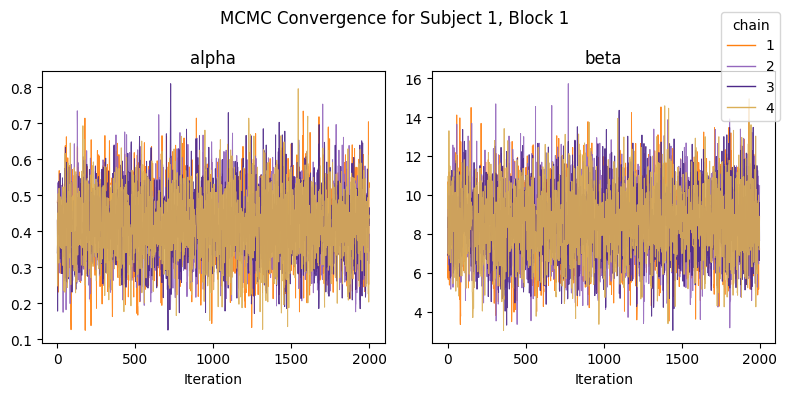


Calculating Summary Statistics (including R-hat, ESS)...
Summary Statistics:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
alpha  0.416  0.094   0.244    0.599      0.001    0.001    6073.0    4571.0    1.0
beta   8.466  1.827   5.068   11.736      0.024    0.021    5526.0    3290.0    1.0
Number of samples: 8000
Performing Kernel Density Estimation...
KDE calculation finished.
Run 1: Starting optimization from initial guess: alpha=0.1375, beta=22.3338
  alpha: 0.137508, beta: 22.333786, KDE density: 9.36e-75
Run 2: Starting optimization from initial guess: alpha=0.5788, beta=26.5705
  alpha: 0.578838, beta: 26.570527, KDE density: 1.964e-187
Run 3: Starting optimization from initial guess: alpha=0.0957, beta=6.7325
  alpha: 0.403502, beta: 7.980440, KDE density: 0.8616
Run 4: Starting optimization from initial guess: alpha=0.9152, beta=12.6564
  alpha: 0.915229, beta: 12.656368, KDE density: 4.94e-13
Run 5: Starting optimization from initial gues

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


  alpha: 0.318621, beta: 7.549773, KDE density: 0.4596
Run 30: Starting optimization from initial guess: alpha=0.8823, beta=4.5655
  alpha: 0.882283, beta: 4.565507, KDE density: 1.123e-16
Run 31: Starting optimization from initial guess: alpha=0.6741, beta=24.2833
  alpha: 0.674075, beta: 24.283334, KDE density: 3.718e-139
Run 32: Starting optimization from initial guess: alpha=0.9199, beta=29.6933
  Optimization failed to converge. Message: ABNORMAL_TERMINATION_IN_LNSRCH
Run 33: Starting optimization from initial guess: alpha=0.5570, beta=24.3839
  alpha: 0.556959, beta: 24.383919, KDE density: 3.681e-124
Run 34: Starting optimization from initial guess: alpha=0.9697, beta=19.5450
  alpha: 0.969695, beta: 19.545019, KDE density: 2.012e-94
Run 35: Starting optimization from initial guess: alpha=0.2098, beta=23.5674
  alpha: 0.209794, beta: 23.567406, KDE density: 5.424e-88
Run 36: Starting optimization from initial guess: alpha=0.4709, beta=27.7192
  alpha: 0.470938, beta: 27.719163, 


Building: found in cache, done.Sampling:   0%
Sampling:  25% (3000/12000)
Sampling:  50% (6000/12000)
Sampling:  75% (9000/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.29 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.21 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.22 seconds.
  Adjust your expectations accordingly!


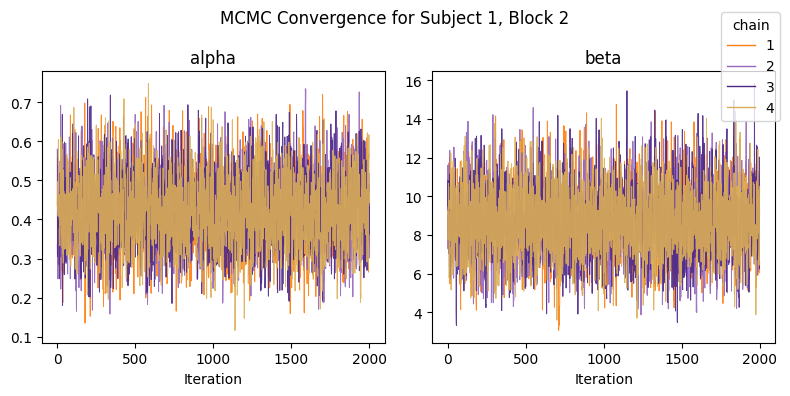


Calculating Summary Statistics (including R-hat, ESS)...
Summary Statistics:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
alpha  0.423  0.092   0.247    0.596      0.001    0.001    4787.0    4088.0    1.0
beta   8.582  1.784   5.330   11.940      0.025    0.021    4820.0    3933.0    1.0
Number of samples: 8000
Performing Kernel Density Estimation...
KDE calculation finished.
Run 1: Starting optimization from initial guess: alpha=0.8696, beta=3.9287
  alpha: 0.869561, beta: 3.928706, KDE density: 1.093e-21
Run 2: Starting optimization from initial guess: alpha=0.5704, beta=22.6040
  alpha: 0.570385, beta: 22.604028, KDE density: 3.939e-66
Run 3: Starting optimization from initial guess: alpha=0.3677, beta=25.7549
  alpha: 0.367707, beta: 25.754938, KDE density: 1.825e-154
Run 4: Starting optimization from initial guess: alpha=0.9460, beta=11.6241
  alpha: 0.946036, beta: 11.624138, KDE density: 1.112e-27
Run 5: Starting optimization from initial

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


  alpha: 0.423227, beta: 8.803716, KDE density: 0.9209
Run 20: Starting optimization from initial guess: alpha=0.7115, beta=28.1047
  alpha: 0.711470, beta: 28.104670, KDE density: 2.431e-225
Run 21: Starting optimization from initial guess: alpha=0.9551, beta=0.1326
  alpha: 0.955079, beta: 0.132575, KDE density: 1.843e-60
Run 22: Starting optimization from initial guess: alpha=0.6125, beta=24.2028
  alpha: 0.612524, beta: 24.202827, KDE density: 7.082e-101
Run 23: Starting optimization from initial guess: alpha=0.2138, beta=11.5705
  alpha: 0.423231, beta: 8.803696, KDE density: 0.9209
Run 24: Starting optimization from initial guess: alpha=0.1285, beta=26.6569
  alpha: 0.128468, beta: 26.656946, KDE density: 1.501e-181
Run 25: Starting optimization from initial guess: alpha=0.6540, beta=12.2054
  alpha: 0.423221, beta: 8.803635, KDE density: 0.9209
Run 26: Starting optimization from initial guess: alpha=0.3698, beta=25.3757
  alpha: 0.369794, beta: 25.375651, KDE density: 2.47e-144



Building: found in cache, done.Sampling:   0%
Sampling:  25% (3000/12000)
Sampling:  50% (6000/12000)
Sampling:  75% (9000/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 1.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.18 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.3 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.13 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.19 seconds.
  Adjust your expectations accordingly!


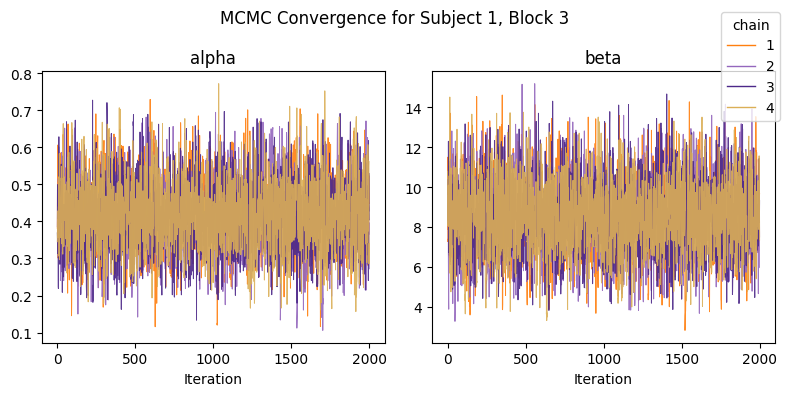


Calculating Summary Statistics (including R-hat, ESS)...
Summary Statistics:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
alpha  0.418  0.096   0.237    0.598      0.001    0.001    4883.0    3642.0    1.0
beta   8.476  1.840   5.131   11.962      0.024    0.020    5653.0    3914.0    1.0
Number of samples: 8000
Performing Kernel Density Estimation...
KDE calculation finished.
Run 1: Starting optimization from initial guess: alpha=0.7789, beta=27.8078
  alpha: 0.778877, beta: 27.807820, KDE density: 6.541e-274
Run 2: Starting optimization from initial guess: alpha=0.8838, beta=25.0041
  alpha: 0.883845, beta: 25.004066, KDE density: 7.231e-223
Run 3: Starting optimization from initial guess: alpha=0.2796, beta=20.1593
  alpha: 0.279624, beta: 20.159323, KDE density: 2.627e-36
Run 4: Starting optimization from initial guess: alpha=0.6402, beta=3.7037
  alpha: 0.417337, beta: 8.747061, KDE density: 0.8069
Run 5: Starting optimization from initial g

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


  alpha: 0.417347, beta: 8.747403, KDE density: 0.8069
Run 48: Starting optimization from initial guess: alpha=0.8092, beta=2.7494
  alpha: 0.809219, beta: 2.749443, KDE density: 1.816e-14
Run 49: Starting optimization from initial guess: alpha=0.4365, beta=22.2684
  alpha: 0.436530, beta: 22.268376, KDE density: 2.349e-71
Run 50: Starting optimization from initial guess: alpha=0.1009, beta=27.6118
  alpha: 0.100913, beta: 27.611811, KDE density: 1.102e-207
Run 51: Starting optimization from initial guess: alpha=0.1504, beta=17.6238
  alpha: 0.150428, beta: 17.623847, KDE density: 2.009e-15
Run 52: Starting optimization from initial guess: alpha=0.2507, beta=1.5756
  alpha: 0.250725, beta: 1.575631, KDE density: 1.372e-07
Run 53: Starting optimization from initial guess: alpha=0.8860, beta=25.6450
  alpha: 0.886050, beta: 25.645039, KDE density: 3.389e-242
Run 54: Starting optimization from initial guess: alpha=0.1304, beta=11.5374
  alpha: 0.417414, beta: 8.747182, KDE density: 0.8069


Building: found in cache, done.Sampling:   0%
Sampling:  25% (3000/12000)
Sampling:  50% (6000/12000)
Sampling:  75% (9000/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 5.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.54 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.38 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.17 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.2 seconds.
  Adjust your expectations accordingly!


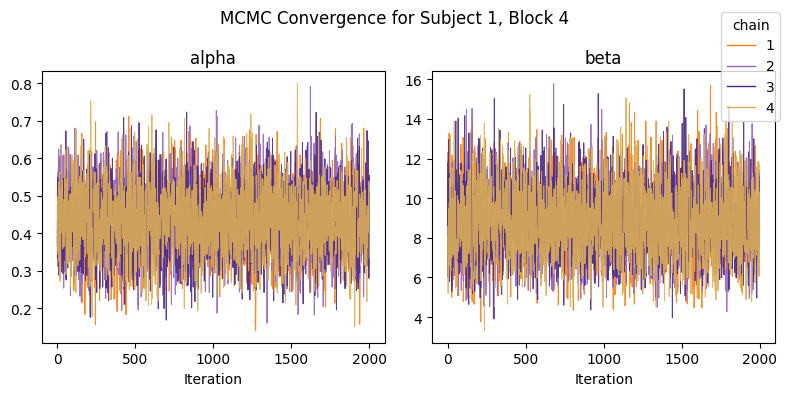


Calculating Summary Statistics (including R-hat, ESS)...
Summary Statistics:
        mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
alpha  0.435  0.09   0.252    0.592      0.001    0.001    5815.0    5014.0    1.0
beta   8.793  1.75   5.423   11.925      0.024    0.019    5397.0    4615.0    1.0
Number of samples: 8000
Performing Kernel Density Estimation...
KDE calculation finished.
Run 1: Starting optimization from initial guess: alpha=0.6301, beta=20.5846
  alpha: 0.630136, beta: 20.584606, KDE density: 3.184e-45
Run 2: Starting optimization from initial guess: alpha=0.7646, beta=29.0132
  alpha: 0.764597, beta: 29.013228, KDE density: 5.853e-303
Run 3: Starting optimization from initial guess: alpha=0.1528, beta=26.4475
  alpha: 0.152831, beta: 26.447493, KDE density: 3.687e-184
Run 4: Starting optimization from initial guess: alpha=0.5075, beta=16.4295
  alpha: 0.421173, beta: 8.203677, KDE density: 0.9436
Run 5: Starting optimization from initial gue

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


  alpha: 0.421172, beta: 8.203705, KDE density: 0.9436
Run 41: Starting optimization from initial guess: alpha=0.9083, beta=19.9868
  alpha: 0.908319, beta: 19.986811, KDE density: 1.461e-95
Run 42: Starting optimization from initial guess: alpha=0.2774, beta=26.2461
  alpha: 0.277381, beta: 26.246116, KDE density: 5.859e-167
Run 43: Starting optimization from initial guess: alpha=0.7480, beta=3.2788
  alpha: 0.748047, beta: 3.278754, KDE density: 2.353e-09
Run 44: Starting optimization from initial guess: alpha=0.8400, beta=28.1123
  alpha: 0.839988, beta: 28.112314, KDE density: 3.468e-290
Run 45: Starting optimization from initial guess: alpha=0.5121, beta=6.8720
  alpha: 0.421215, beta: 8.203243, KDE density: 0.9436
Run 46: Starting optimization from initial guess: alpha=0.0245, beta=17.5699
  alpha: 0.024535, beta: 17.569872, KDE density: 5.11e-33
Run 47: Starting optimization from initial guess: alpha=0.2549, beta=0.1862
  alpha: 0.254894, beta: 0.186215, KDE density: 2.822e-23
R


Building: found in cache, done.Sampling:   0%
Sampling:   2% (200/12000)
Sampling:   5% (600/12000)
Sampling:  28% (3400/12000)
Sampling:  50% (6000/12000)
Sampling:  75% (9000/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 9.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.98 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.63 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.28 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.29 seconds.
  Adjust your expectations accordingly!


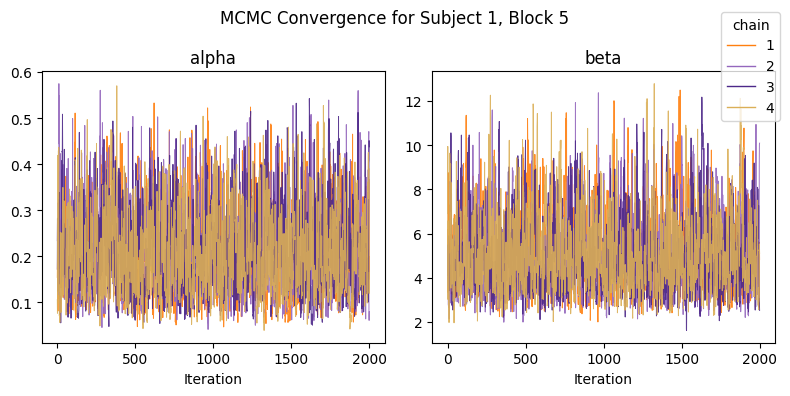


Calculating Summary Statistics (including R-hat, ESS)...
Summary Statistics:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
alpha  0.213  0.095   0.062    0.385      0.002    0.001    1817.0    2177.0    1.0
beta   5.084  1.763   2.377    8.413      0.043    0.035    1788.0    2083.0    1.0
Number of samples: 8000
Performing Kernel Density Estimation...
KDE calculation finished.
Run 1: Starting optimization from initial guess: alpha=0.3997, beta=14.1196
  alpha: 0.399745, beta: 14.119619, KDE density: 1.052e-212
Run 2: Starting optimization from initial guess: alpha=0.4825, beta=7.7528
  alpha: 0.482452, beta: 7.752804, KDE density: 1.857e-60
Run 3: Starting optimization from initial guess: alpha=0.5880, beta=2.8621
  alpha: 0.206214, beta: 4.590161, KDE density: 2.05
Run 4: Starting optimization from initial guess: alpha=0.2151, beta=2.6271
  alpha: 0.206219, beta: 4.590189, KDE density: 2.05
Run 5: Starting optimization from initial guess: alpha=

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


  Optimization failed to converge. Message: ABNORMAL_TERMINATION_IN_LNSRCH
Run 6: Starting optimization from initial guess: alpha=0.7689, beta=29.3153
  Optimization failed to converge. Message: ABNORMAL_TERMINATION_IN_LNSRCH
Run 7: Starting optimization from initial guess: alpha=0.0079, beta=0.8816
  alpha: 0.007900, beta: 0.881636, KDE density: 5.994e-78
Run 8: Starting optimization from initial guess: alpha=0.0730, beta=0.1962
  alpha: 0.072970, beta: 0.196242, KDE density: 5.625e-62
Run 9: Starting optimization from initial guess: alpha=0.5884, beta=8.7314
  alpha: 0.588405, beta: 8.731354, KDE density: 2.273e-162
Run 10: Starting optimization from initial guess: alpha=0.5755, beta=13.8961
  Optimization failed to converge. Message: ABNORMAL_TERMINATION_IN_LNSRCH
Run 11: Starting optimization from initial guess: alpha=0.6285, beta=0.9982
  alpha: 0.625424, beta: 0.998648, KDE density: 8.418e-05
Run 12: Starting optimization from initial guess: alpha=0.2941, beta=16.1951
  alpha: 0.


Building: found in cache, done.Sampling:   0%
Sampling:   8% (900/12000)
Sampling:  32% (3900/12000)
Sampling:  58% (6900/12000)
Sampling:  82% (9900/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 2.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.29 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.65 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.31 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.17 seconds.
  Adjust your expectations accordingly!


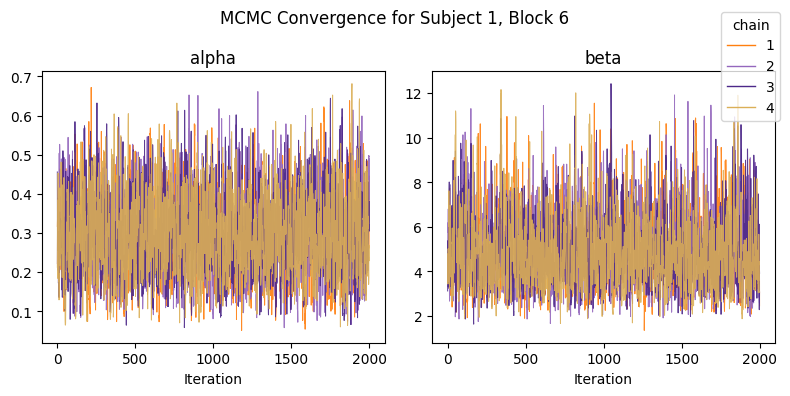


Calculating Summary Statistics (including R-hat, ESS)...
Summary Statistics:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
alpha  0.294  0.106   0.111    0.498      0.002    0.001    2839.0    2558.0    1.0
beta   4.901  1.619   2.249    7.926      0.032    0.028    2679.0    2828.0    1.0
Number of samples: 8000
Performing Kernel Density Estimation...
KDE calculation finished.
Run 1: Starting optimization from initial guess: alpha=0.2577, beta=15.4846
  alpha: 0.257667, beta: 15.484607, KDE density: 4.421e-96
Run 2: Starting optimization from initial guess: alpha=0.9514, beta=28.8661
  Optimization failed to converge. Message: ABNORMAL_TERMINATION_IN_LNSRCH
Run 3: Starting optimization from initial guess: alpha=0.8821, beta=24.0408
  Optimization failed to converge. Message: ABNORMAL_TERMINATION_IN_LNSRCH
Run 4: Starting optimization from initial guess: alpha=0.4210, beta=16.2802
  alpha: 0.421043, beta: 16.280160, KDE density: 1.197e-236
Run 5: 

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


  alpha: 0.298171, beta: 4.424874, KDE density: 1.408
Run 23: Starting optimization from initial guess: alpha=0.3590, beta=21.6395
  Optimization failed to converge. Message: ABNORMAL_TERMINATION_IN_LNSRCH
Run 24: Starting optimization from initial guess: alpha=0.6967, beta=18.9915
  Optimization failed to converge. Message: ABNORMAL_TERMINATION_IN_LNSRCH
Run 25: Starting optimization from initial guess: alpha=0.2864, beta=19.1794
  alpha: 0.286437, beta: 19.179427, KDE density: 9.445e-289
Run 26: Starting optimization from initial guess: alpha=0.5895, beta=6.1289
  alpha: 0.589457, beta: 6.128857, KDE density: 7.649e-12
Run 27: Starting optimization from initial guess: alpha=0.5358, beta=3.8727
  alpha: 0.298176, beta: 4.425157, KDE density: 1.408
Run 28: Starting optimization from initial guess: alpha=0.4910, beta=23.6417
  Optimization failed to converge. Message: ABNORMAL_TERMINATION_IN_LNSRCH
Run 29: Starting optimization from initial guess: alpha=0.2681, beta=18.3801
  alpha: 0.2


Building: found in cache, done.Sampling:   0%
Sampling:  25% (3000/12000)
Sampling:  50% (6000/12000)
Sampling:  75% (9000/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 1.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.18 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.17 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.14 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.2 seconds.
  Adjust your expectations accordingly!


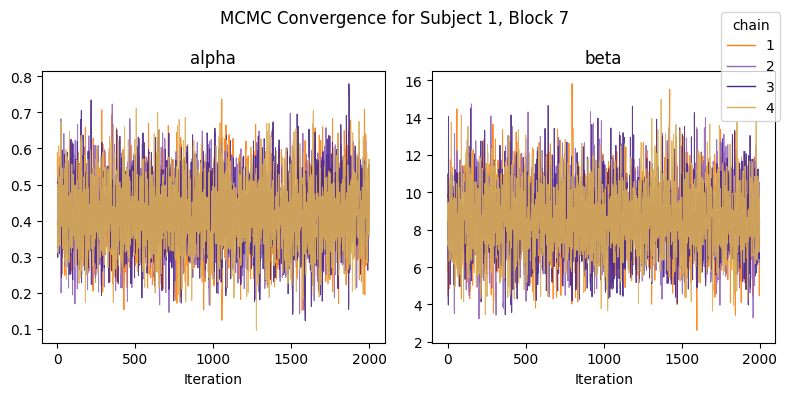


Calculating Summary Statistics (including R-hat, ESS)...
Summary Statistics:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
alpha  0.418  0.095   0.237    0.599      0.001    0.001    5900.0    4086.0    1.0
beta   8.466  1.799   5.139   11.862      0.024    0.020    5350.0    4366.0    1.0
Number of samples: 8000
Performing Kernel Density Estimation...
KDE calculation finished.
Run 1: Starting optimization from initial guess: alpha=0.6821, beta=1.6143
  alpha: 0.682149, beta: 1.614289, KDE density: 1.332e-10
Run 2: Starting optimization from initial guess: alpha=0.2441, beta=11.2321
  alpha: 0.414827, beta: 8.015780, KDE density: 0.9616
Run 3: Starting optimization from initial guess: alpha=0.5895, beta=14.9449
  alpha: 0.587964, beta: 14.944789, KDE density: 2.309e-05
Run 4: Starting optimization from initial guess: alpha=0.2149, beta=21.5071
  alpha: 0.214859, beta: 21.507114, KDE density: 4.455e-56
Run 5: Starting optimization from initial gues

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


  alpha: 0.414812, beta: 8.016006, KDE density: 0.9616
Run 51: Starting optimization from initial guess: alpha=0.3524, beta=28.4213
  alpha: 0.352436, beta: 28.421283, KDE density: 3.584e-217
Run 52: Starting optimization from initial guess: alpha=0.0339, beta=20.7628
  alpha: 0.033863, beta: 20.762770, KDE density: 1.542e-71
Run 53: Starting optimization from initial guess: alpha=0.2148, beta=27.1006
  alpha: 0.214784, beta: 27.100609, KDE density: 1.461e-180
Run 54: Starting optimization from initial guess: alpha=0.9080, beta=27.4593
  alpha: 0.907999, beta: 27.459345, KDE density: 3.54e-300
Run 55: Starting optimization from initial guess: alpha=0.5325, beta=24.6396
  alpha: 0.532545, beta: 24.639552, KDE density: 1.229e-125
Run 56: Starting optimization from initial guess: alpha=0.8932, beta=4.1525
  alpha: 0.893165, beta: 4.152507, KDE density: 4.93e-17
Run 57: Starting optimization from initial guess: alpha=0.4811, beta=0.4665
  alpha: 0.481072, beta: 0.466485, KDE density: 4.186


Building: found in cache, done.Sampling:   0%
Sampling:  25% (3000/12000)
Sampling:  50% (6000/12000)
Sampling:  75% (9000/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 2.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.13 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.21 seconds.
  Adjust your expectations accordingly!


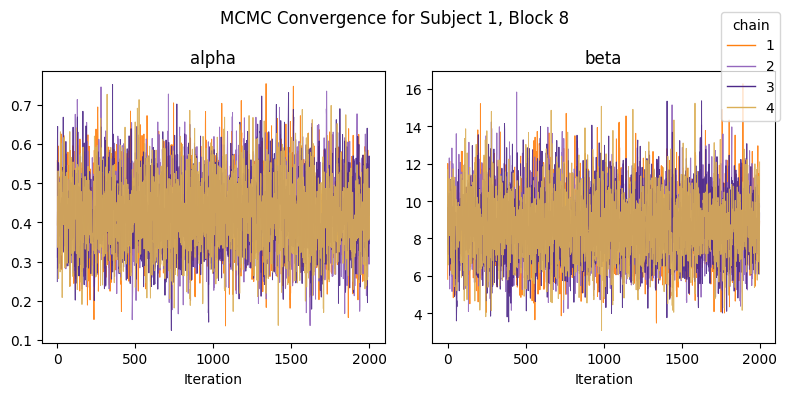


Calculating Summary Statistics (including R-hat, ESS)...
Summary Statistics:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
alpha  0.423  0.094   0.249    0.599      0.001    0.001    5272.0    4857.0    1.0
beta   8.597  1.806   5.369   12.031      0.023    0.020    6078.0    4738.0    1.0
Number of samples: 8000
Performing Kernel Density Estimation...
KDE calculation finished.
Run 1: Starting optimization from initial guess: alpha=0.4343, beta=5.5632
  alpha: 0.424452, beta: 8.227595, KDE density: 0.8832
Run 2: Starting optimization from initial guess: alpha=0.1610, beta=1.2354
  alpha: 0.160953, beta: 1.235444, KDE density: 2.065e-22
Run 3: Starting optimization from initial guess: alpha=0.5589, beta=2.4519
  alpha: 0.558964, beta: 2.452006, KDE density: 7.635e-06
Run 4: Starting optimization from initial guess: alpha=0.6145, beta=9.6287
  alpha: 0.424485, beta: 8.227601, KDE density: 0.8832
Run 5: Starting optimization from initial guess: alpha

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


  alpha: 0.424464, beta: 8.226104, KDE density: 0.8832
Run 41: Starting optimization from initial guess: alpha=0.4180, beta=28.7058
  alpha: 0.417961, beta: 28.705793, KDE density: 2.316e-212
Run 42: Starting optimization from initial guess: alpha=0.0366, beta=6.5300
  alpha: 0.036631, beta: 6.530019, KDE density: 6.635e-10
Run 43: Starting optimization from initial guess: alpha=0.8169, beta=9.8087
  alpha: 0.815068, beta: 9.808679, KDE density: 1.642e-05
Run 44: Starting optimization from initial guess: alpha=0.4081, beta=3.2719
  alpha: 0.424491, beta: 8.227624, KDE density: 0.8832
Run 45: Starting optimization from initial guess: alpha=0.5606, beta=22.5734
  alpha: 0.560626, beta: 22.573396, KDE density: 1.249e-73
Run 46: Starting optimization from initial guess: alpha=0.1236, beta=2.2602
  alpha: 0.123609, beta: 2.260194, KDE density: 9.701e-20
Run 47: Starting optimization from initial guess: alpha=0.1882, beta=26.3183
  alpha: 0.188179, beta: 26.318280, KDE density: 1.453e-150
Ru


Building: found in cache, done.Sampling:   0%
Sampling:   1% (100/12000)
Sampling:   3% (400/12000)
Sampling:  17% (2000/12000)
Sampling:  39% (4700/12000)
Sampling:  64% (7700/12000)
Sampling:  89% (10700/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 5.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.56 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.56 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.43 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.47 seconds.
  Adjust your expectations accordingly!


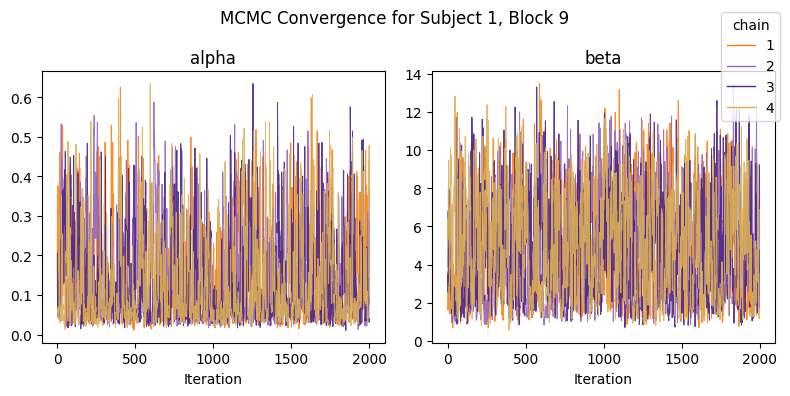


Calculating Summary Statistics (including R-hat, ESS)...
Summary Statistics:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
alpha  0.133  0.115   0.017    0.364      0.004    0.002     957.0    2452.0    1.0
beta   4.841  2.692   0.975    9.452      0.086    0.029     963.0    2391.0    1.0
Number of samples: 8000
Performing Kernel Density Estimation...
KDE calculation finished.
Run 1: Starting optimization from initial guess: alpha=0.1084, beta=9.0128
  alpha: 0.060228, beta: 5.910517, KDE density: 1.749
Run 2: Starting optimization from initial guess: alpha=0.6986, beta=18.9785
  Optimization failed to converge. Message: ABNORMAL_TERMINATION_IN_LNSRCH
Run 3: Starting optimization from initial guess: alpha=0.8451, beta=18.4515
  Optimization failed to converge. Message: ABNORMAL_TERMINATION_IN_LNSRCH
Run 4: Starting optimization from initial guess: alpha=0.0122, beta=10.0353
  alpha: 0.012170, beta: 10.035329, KDE density: 0.4245
Run 5: Starting o

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


  alpha: 0.364523, beta: 8.344233, KDE density: 5.589e-30
Run 22: Starting optimization from initial guess: alpha=0.3831, beta=20.7693
  Optimization failed to converge. Message: ABNORMAL_TERMINATION_IN_LNSRCH
Run 23: Starting optimization from initial guess: alpha=0.3674, beta=3.1260
  alpha: 0.060228, beta: 5.910488, KDE density: 1.749
Run 24: Starting optimization from initial guess: alpha=0.6153, beta=1.1614
  alpha: 0.065826, beta: 5.679720, KDE density: 1.732
Run 25: Starting optimization from initial guess: alpha=0.6043, beta=8.3275
  alpha: 0.604341, beta: 8.327493, KDE density: 3.033e-73
Run 26: Starting optimization from initial guess: alpha=0.5451, beta=7.2073
  alpha: 0.545143, beta: 7.207329, KDE density: 5.284e-36
Run 27: Starting optimization from initial guess: alpha=0.2700, beta=27.1029
  Optimization failed to converge. Message: ABNORMAL_TERMINATION_IN_LNSRCH
Run 28: Starting optimization from initial guess: alpha=0.1820, beta=21.7203
  alpha: 0.182004, beta: 21.72033


Building: found in cache, done.Sampling:   0%
Sampling:   2% (300/12000)
Sampling:  10% (1200/12000)
Sampling:  35% (4200/12000)
Sampling:  60% (7200/12000)
Sampling:  82% (9900/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 4.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.48 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.46 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.29 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.28 seconds.
  Adjust your expectations accordingly!


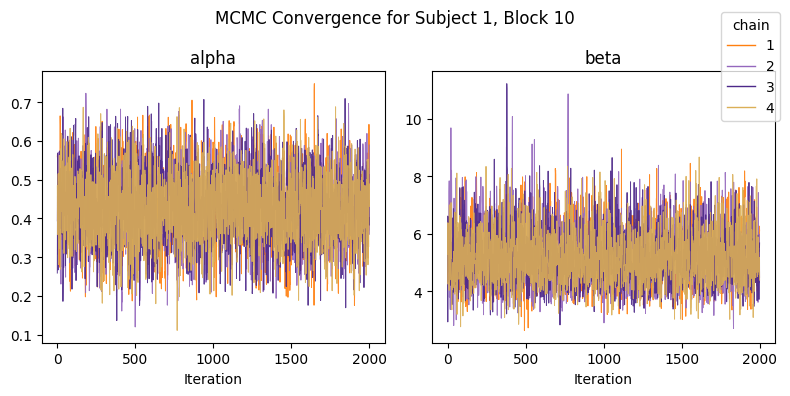


Calculating Summary Statistics (including R-hat, ESS)...
Summary Statistics:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
alpha  0.428  0.090   0.255    0.599      0.001    0.001    4847.0    4432.0    1.0
beta   5.217  0.944   3.592    7.018      0.014    0.013    4612.0    5044.0    1.0
Number of samples: 8000
Performing Kernel Density Estimation...
KDE calculation finished.
Run 1: Starting optimization from initial guess: alpha=0.9562, beta=7.7961
  alpha: 0.956200, beta: 7.796116, KDE density: 2.484e-57
Run 2: Starting optimization from initial guess: alpha=0.7542, beta=10.7054
  alpha: 0.754198, beta: 10.705389, KDE density: 2.843e-72
Run 3: Starting optimization from initial guess: alpha=0.3130, beta=3.4037
  alpha: 0.536958, beta: 3.476614, KDE density: 0.2508
Run 4: Starting optimization from initial guess: alpha=0.8151, beta=16.4815
  Optimization failed to converge. Message: ABNORMAL_TERMINATION_IN_LNSRCH
Run 5: Starting optimization fr

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


  alpha: 0.618588, beta: 10.387329, KDE density: 2.692e-37
Run 24: Starting optimization from initial guess: alpha=0.1048, beta=29.9025
  Optimization failed to converge. Message: ABNORMAL_TERMINATION_IN_LNSRCH
Run 25: Starting optimization from initial guess: alpha=0.4458, beta=14.1543
  alpha: 0.445805, beta: 14.154341, KDE density: 6.446e-113
Run 26: Starting optimization from initial guess: alpha=0.0906, beta=28.9206
  Optimization failed to converge. Message: ABNORMAL_TERMINATION_IN_LNSRCH
Run 27: Starting optimization from initial guess: alpha=0.6681, beta=6.2821
  alpha: 0.425135, beta: 5.057902, KDE density: 1.998
Run 28: Starting optimization from initial guess: alpha=0.9062, beta=15.5487
  Optimization failed to converge. Message: ABNORMAL_TERMINATION_IN_LNSRCH
Run 29: Starting optimization from initial guess: alpha=0.9481, beta=25.0230
  Optimization failed to converge. Message: ABNORMAL_TERMINATION_IN_LNSRCH
Run 30: Starting optimization from initial guess: alpha=0.5142, be


Building: found in cache, done.Sampling:   0%
Sampling:  25% (3000/12000)
Sampling:  50% (6000/12000)
Sampling:  75% (9000/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 2.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.28 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.26 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.13 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.14 seconds.
  Adjust your expectations accordingly!


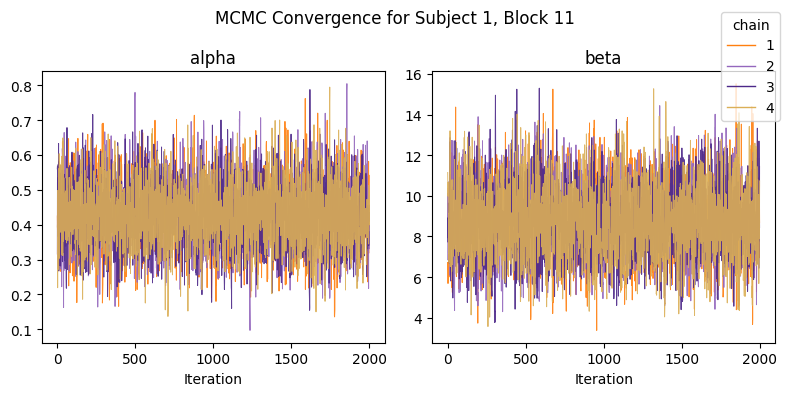


Calculating Summary Statistics (including R-hat, ESS)...
Summary Statistics:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
alpha  0.429  0.092   0.248    0.593      0.001    0.001    6255.0    4905.0    1.0
beta   8.725  1.750   5.543   12.061      0.023    0.021    5521.0    4168.0    1.0
Number of samples: 8000
Performing Kernel Density Estimation...
KDE calculation finished.
Run 1: Starting optimization from initial guess: alpha=0.9476, beta=0.5183
  alpha: 0.947567, beta: 0.518298, KDE density: 1.069e-52
Run 2: Starting optimization from initial guess: alpha=0.9179, beta=5.6019
  alpha: 0.917934, beta: 5.601913, KDE density: 5.027e-22
Run 3: Starting optimization from initial guess: alpha=0.6127, beta=15.4512
  alpha: 0.612628, beta: 15.451218, KDE density: 4.121e-07
Run 4: Starting optimization from initial guess: alpha=0.7469, beta=24.9274
  alpha: 0.746896, beta: 24.927449, KDE density: 1.001e-187
Run 5: Starting optimization from initial g

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


  alpha: 0.448483, beta: 8.626036, KDE density: 0.9236
Run 38: Starting optimization from initial guess: alpha=0.8157, beta=0.8617
  alpha: 0.815743, beta: 0.861720, KDE density: 9.906e-29
Run 39: Starting optimization from initial guess: alpha=0.2159, beta=8.4305
  alpha: 0.426070, beta: 8.517342, KDE density: 0.9972
Run 40: Starting optimization from initial guess: alpha=0.5455, beta=8.5377
  alpha: 0.426038, beta: 8.527937, KDE density: 0.9971
Run 41: Starting optimization from initial guess: alpha=0.5091, beta=10.5506
  alpha: 0.426060, beta: 8.516800, KDE density: 0.9972
Run 42: Starting optimization from initial guess: alpha=0.9189, beta=17.2431
  alpha: 0.918930, beta: 17.243050, KDE density: 5.959e-85
Run 43: Starting optimization from initial guess: alpha=0.4137, beta=9.0075
  alpha: 0.426069, beta: 8.517137, KDE density: 0.9972
Run 44: Starting optimization from initial guess: alpha=0.2636, beta=6.8093
  alpha: 0.426068, beta: 8.517125, KDE density: 0.9972
Run 45: Starting op


Building: found in cache, done.Sampling:   0%
Sampling:  25% (3000/12000)
Sampling:  50% (6000/12000)
Sampling:  75% (9000/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 1.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.18 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.16 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 8e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.08 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.12 seconds.
  Adjust your expectations accordingly!


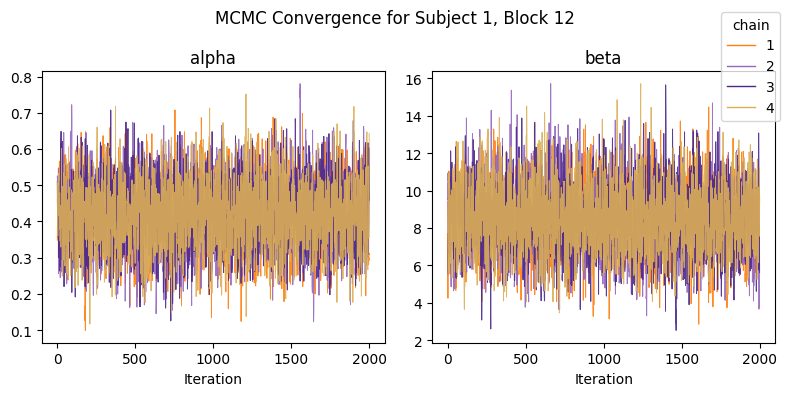


Calculating Summary Statistics (including R-hat, ESS)...
Summary Statistics:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
alpha  0.418  0.095   0.249    0.606      0.001    0.001    6139.0    5012.0    1.0
beta   8.422  1.840   5.079   11.908      0.025    0.021    5182.0    3979.0    1.0
Number of samples: 8000
Performing Kernel Density Estimation...
KDE calculation finished.
Run 1: Starting optimization from initial guess: alpha=0.9500, beta=17.4421
  alpha: 0.949981, beta: 17.442061, KDE density: 5.113e-59
Run 2: Starting optimization from initial guess: alpha=0.8214, beta=19.1439
  alpha: 0.821442, beta: 19.143885, KDE density: 9.186e-57
Run 3: Starting optimization from initial guess: alpha=0.4845, beta=18.1734
  alpha: 0.484501, beta: 18.173392, KDE density: 2.98e-12
Run 4: Starting optimization from initial guess: alpha=0.4718, beta=3.7907
  alpha: 0.405606, beta: 8.070440, KDE density: 0.8374
Run 5: Starting optimization from initial gues

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


  alpha: 0.405623, beta: 8.070609, KDE density: 0.8374
Run 69: Starting optimization from initial guess: alpha=0.9448, beta=9.8921
  alpha: 0.944846, beta: 9.892098, KDE density: 7.832e-17
Run 70: Starting optimization from initial guess: alpha=0.3302, beta=14.4703
  alpha: 0.405614, beta: 8.070542, KDE density: 0.8374
Run 71: Starting optimization from initial guess: alpha=0.3642, beta=15.1495
  alpha: 0.439206, beta: 15.144985, KDE density: 0.003902
Run 72: Starting optimization from initial guess: alpha=0.8362, beta=18.0824
  alpha: 0.836230, beta: 18.082386, KDE density: 6.221e-44
Run 73: Starting optimization from initial guess: alpha=0.3990, beta=8.1808
  alpha: 0.407456, beta: 8.180180, KDE density: 0.8366
Run 74: Starting optimization from initial guess: alpha=0.2195, beta=15.6554
  alpha: 0.220774, beta: 15.655335, KDE density: 1.12e-05
Run 75: Starting optimization from initial guess: alpha=0.4689, beta=18.5617
  alpha: 0.468891, beta: 18.561693, KDE density: 2.726e-14
Run 76


Building: found in cache, done.Sampling:   0%
Sampling:  25% (3000/12000)
Sampling:  50% (6000/12000)
Sampling:  75% (9000/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 2.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.21 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
  Adjust your expectations accordingly!


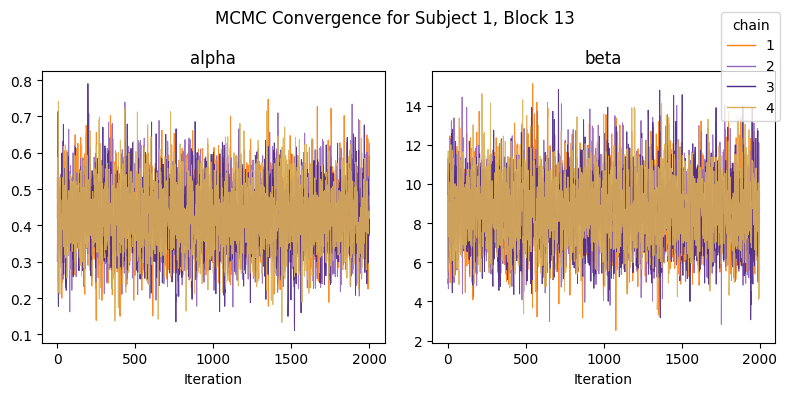


Calculating Summary Statistics (including R-hat, ESS)...
Summary Statistics:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
alpha  0.423  0.091   0.259    0.600      0.001    0.001    6648.0    4832.0    1.0
beta   8.601  1.772   5.377   11.919      0.022    0.022    6166.0    4873.0    1.0
Number of samples: 8000
Performing Kernel Density Estimation...
KDE calculation finished.
Run 1: Starting optimization from initial guess: alpha=0.0941, beta=5.9704
  alpha: 0.094094, beta: 5.970369, KDE density: 1.913e-09
Run 2: Starting optimization from initial guess: alpha=0.6973, beta=15.7059
  alpha: 0.697324, beta: 15.705871, KDE density: 5.471e-09
Run 3: Starting optimization from initial guess: alpha=0.7315, beta=18.5414
  alpha: 0.731508, beta: 18.541405, KDE density: 6.041e-38
Run 4: Starting optimization from initial guess: alpha=0.7524, beta=13.9231
  alpha: 0.752432, beta: 13.923109, KDE density: 7.938e-08
Run 5: Starting optimization from initial 

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0

Building: found in cache, done.Sampling:   0%
Sampling:  25% (3000/12000)
Sampling:  50% (6000/12000)
Sampling:  75% (9000/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 1.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.18 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.15 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.15 seconds.
  

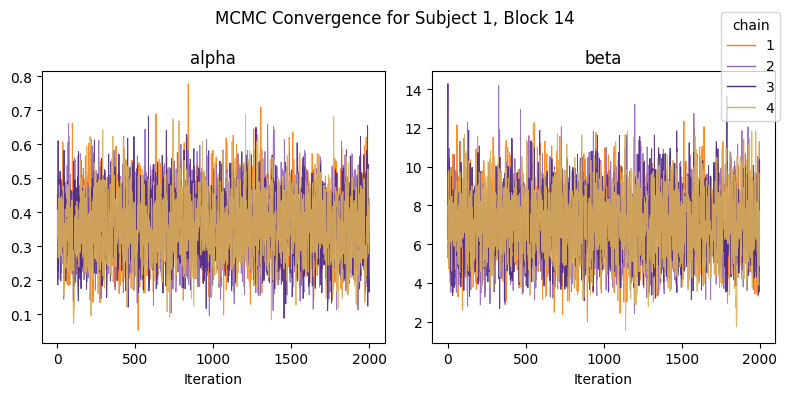


Calculating Summary Statistics (including R-hat, ESS)...
Summary Statistics:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
alpha  0.358  0.096   0.174    0.529      0.001    0.001    4319.0    4296.0    1.0
beta   6.936  1.705   3.728   10.052      0.025    0.019    4418.0    3918.0    1.0
Number of samples: 8000
Performing Kernel Density Estimation...
KDE calculation finished.
Run 1: Starting optimization from initial guess: alpha=0.4523, beta=16.8684
  alpha: 0.452346, beta: 16.868427, KDE density: 2.072e-41
Run 2: Starting optimization from initial guess: alpha=0.4769, beta=24.7076
  alpha: 0.476852, beta: 24.707643, KDE density: 3.379e-263
Run 3: Starting optimization from initial guess: alpha=0.6305, beta=14.1054
  alpha: 0.630541, beta: 14.105399, KDE density: 9.986e-24
Run 4: Starting optimization from initial guess: alpha=0.1648, beta=18.1043
  alpha: 0.164837, beta: 18.104332, KDE density: 3.617e-25
Run 5: Starting optimization from initi

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


  alpha: 0.329384, beta: 6.696722, KDE density: 0.9774
Run 24: Starting optimization from initial guess: alpha=0.1488, beta=6.7079
  alpha: 0.329017, beta: 6.711155, KDE density: 0.9774
Run 25: Starting optimization from initial guess: alpha=0.7618, beta=7.1317
  alpha: 0.761612, beta: 7.131662, KDE density: 1.14e-06
Run 26: Starting optimization from initial guess: alpha=0.4351, beta=17.5682
  alpha: 0.435097, beta: 17.568153, KDE density: 1.257e-51
Run 27: Starting optimization from initial guess: alpha=0.6491, beta=23.3720
  alpha: 0.649129, beta: 23.371976, KDE density: 6.18e-269
Run 28: Starting optimization from initial guess: alpha=0.2645, beta=5.1471
  alpha: 0.329379, beta: 6.696862, KDE density: 0.9774
Run 29: Starting optimization from initial guess: alpha=0.5837, beta=1.8898
  alpha: 0.497552, beta: 5.103503, KDE density: 0.3449
Run 30: Starting optimization from initial guess: alpha=0.7443, beta=12.5772
  alpha: 0.744346, beta: 12.577202, KDE density: 3.234e-34
Run 31: Sta


Building: found in cache, done.Sampling:   0%
Sampling:   3% (400/12000)
Sampling:   8% (1000/12000)
Sampling:  33% (4000/12000)
Sampling:  55% (6600/12000)
Sampling:  75% (9000/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 4.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.42 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.43 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
  Adjust your expectations accordingly!


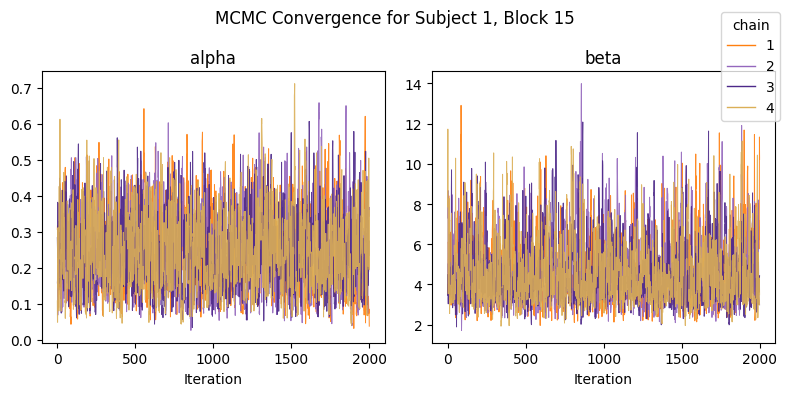


Calculating Summary Statistics (including R-hat, ESS)...
Summary Statistics:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
alpha  0.241  0.107   0.064    0.433      0.002    0.001    1807.0    2107.0    1.0
beta   4.665  1.644   2.296    7.930      0.041    0.036    1793.0    2218.0    1.0
Number of samples: 8000
Performing Kernel Density Estimation...
KDE calculation finished.
Run 1: Starting optimization from initial guess: alpha=0.5092, beta=7.2670
  alpha: 0.509192, beta: 7.266960, KDE density: 1.077e-30
Run 2: Starting optimization from initial guess: alpha=0.6094, beta=17.6079
  Optimization failed to converge. Message: ABNORMAL_TERMINATION_IN_LNSRCH
Run 3: Starting optimization from initial guess: alpha=0.9408, beta=13.7043
  Optimization failed to converge. Message: ABNORMAL_TERMINATION_IN_LNSRCH
Run 4: Starting optimization from initial guess: alpha=0.6361, beta=17.6550
  Optimization failed to converge. Message: ABNORMAL_TERMINATION_IN_L

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


  Optimization failed to converge. Message: ABNORMAL_TERMINATION_IN_LNSRCH
Run 20: Starting optimization from initial guess: alpha=0.2450, beta=21.2984
  Optimization failed to converge. Message: ABNORMAL_TERMINATION_IN_LNSRCH
Run 21: Starting optimization from initial guess: alpha=0.3637, beta=20.1029
  Optimization failed to converge. Message: ABNORMAL_TERMINATION_IN_LNSRCH
Run 22: Starting optimization from initial guess: alpha=0.1615, beta=10.6637
  alpha: 0.159561, beta: 10.663692, KDE density: 1.368e-05
Run 23: Starting optimization from initial guess: alpha=0.7823, beta=14.8000
  Optimization failed to converge. Message: ABNORMAL_TERMINATION_IN_LNSRCH
Run 24: Starting optimization from initial guess: alpha=0.8152, beta=24.7925
  Optimization failed to converge. Message: ABNORMAL_TERMINATION_IN_LNSRCH
Run 25: Starting optimization from initial guess: alpha=0.9476, beta=8.4217
  Optimization failed to converge. Message: ABNORMAL_TERMINATION_IN_LNSRCH
Run 26: Starting optimization 


Building: found in cache, done.Sampling:   0%
Sampling:   3% (400/12000)
Sampling:   9% (1100/12000)
Sampling:  34% (4100/12000)
Sampling:  56% (6700/12000)
Sampling:  75% (9000/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 3.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.39 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.32 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.29 seconds.
  Adjust your expectations accordingly!


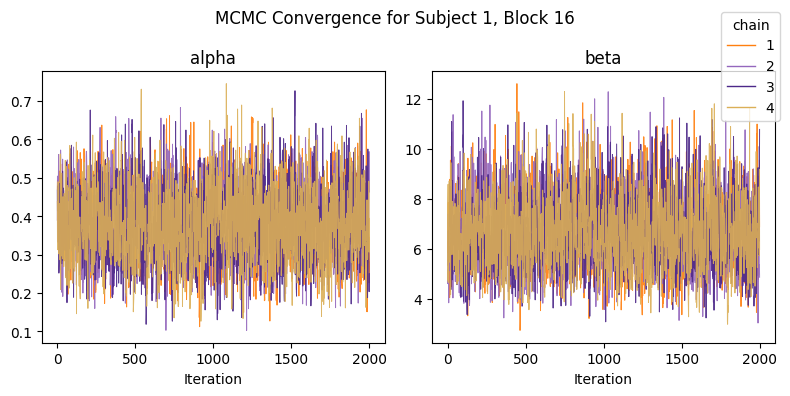


Calculating Summary Statistics (including R-hat, ESS)...
Summary Statistics:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
alpha  0.379  0.093   0.212    0.553      0.002    0.001    3449.0    4000.0    1.0
beta   6.649  1.409   4.037    9.203      0.024    0.015    3468.0    4659.0    1.0
Number of samples: 8000
Performing Kernel Density Estimation...
KDE calculation finished.
Run 1: Starting optimization from initial guess: alpha=0.8030, beta=15.2998
  alpha: 0.803009, beta: 15.299849, KDE density: 8.714e-169
Run 2: Starting optimization from initial guess: alpha=0.7073, beta=3.2291
  alpha: 0.319003, beta: 4.954813, KDE density: 0.3226
Run 3: Starting optimization from initial guess: alpha=0.7314, beta=0.5398
  alpha: 0.731373, beta: 0.539760, KDE density: 3.729e-20
Run 4: Starting optimization from initial guess: alpha=0.0607, beta=15.5000
  alpha: 0.060746, beta: 15.499988, KDE density: 7.64e-22
Run 5: Starting optimization from initial guess

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


  alpha: 0.364052, beta: 6.130900, KDE density: 1.377
Run 10: Starting optimization from initial guess: alpha=0.6258, beta=29.6887
  Optimization failed to converge. Message: ABNORMAL_TERMINATION_IN_LNSRCH
Run 11: Starting optimization from initial guess: alpha=0.0329, beta=27.2543
  Optimization failed to converge. Message: ABNORMAL_TERMINATION_IN_LNSRCH
Run 12: Starting optimization from initial guess: alpha=0.4636, beta=22.2556
  Optimization failed to converge. Message: ABNORMAL_TERMINATION_IN_LNSRCH
Run 13: Starting optimization from initial guess: alpha=0.9272, beta=27.6287
  Optimization failed to converge. Message: ABNORMAL_TERMINATION_IN_LNSRCH
Run 14: Starting optimization from initial guess: alpha=0.9807, beta=24.3912
  Optimization failed to converge. Message: ABNORMAL_TERMINATION_IN_LNSRCH
Run 15: Starting optimization from initial guess: alpha=0.5459, beta=11.5236
  alpha: 0.545901, beta: 11.523573, KDE density: 1.2e-07
Run 16: Starting optimization from initial guess: al


Building: found in cache, done.Sampling:   0%
Sampling:   6% (700/12000)
Sampling:  31% (3700/12000)
Sampling:  56% (6700/12000)
Sampling:  81% (9700/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 3.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.32 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.25 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.15 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.14 seconds.
  Adjust your expectations accordingly!


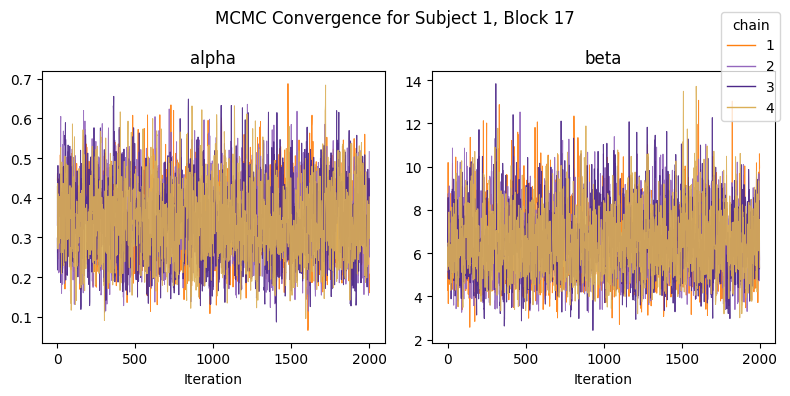


Calculating Summary Statistics (including R-hat, ESS)...
Summary Statistics:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
alpha  0.340  0.094   0.167    0.508      0.002    0.001    3112.0    3617.0    1.0
beta   6.495  1.570   3.877    9.608      0.027    0.019    3311.0    4170.0    1.0
Number of samples: 8000
Performing Kernel Density Estimation...
KDE calculation finished.
Run 1: Starting optimization from initial guess: alpha=0.7479, beta=28.8461
  Optimization failed to converge. Message: ABNORMAL_TERMINATION_IN_LNSRCH
Run 2: Starting optimization from initial guess: alpha=0.1742, beta=18.4411
  alpha: 0.174186, beta: 18.441131, KDE density: 1.008e-40
Run 3: Starting optimization from initial guess: alpha=0.8032, beta=13.9073
  alpha: 0.803248, beta: 13.907313, KDE density: 1.051e-136
Run 4: Starting optimization from initial guess: alpha=0.1277, beta=5.0819
  alpha: 0.313427, beta: 6.519079, KDE density: 1.133
Run 5: Starting optimization 

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


  alpha: 0.351504, beta: 5.795913, KDE density: 1.128
Run 10: Starting optimization from initial guess: alpha=0.0226, beta=1.4193
  alpha: 0.022596, beta: 1.419308, KDE density: 1.814e-47
Run 11: Starting optimization from initial guess: alpha=0.3217, beta=13.8211
  alpha: 0.301753, beta: 13.820643, KDE density: 0.003126
Run 12: Starting optimization from initial guess: alpha=0.6776, beta=18.7636
  alpha: 0.677573, beta: 18.763568, KDE density: 5.201e-232
Run 13: Starting optimization from initial guess: alpha=0.8207, beta=2.9261
  alpha: 0.820665, beta: 2.926105, KDE density: 1.341e-12
Run 14: Starting optimization from initial guess: alpha=0.8724, beta=4.6525
  alpha: 0.872441, beta: 4.652470, KDE density: 1.511e-21
Run 15: Starting optimization from initial guess: alpha=0.4736, beta=16.2976
  alpha: 0.473635, beta: 16.297580, KDE density: 3.49e-55
Run 16: Starting optimization from initial guess: alpha=0.5519, beta=26.8920
  Optimization failed to converge. Message: ABNORMAL_TERMINA

In [ ]:
# for i in range(1,2):
results_df = fit_rl2_model_fmin(df_clean,4,2000)
  #results_df.to_csv(f'rl2_results_{i}.csv', index=False)

In [ ]:
print("\nResults:")
print(results_df)


Results:
    subno  block     alpha      beta
0       1      1  0.403271  7.986636
1       1      2  0.422959  8.753192
2       1      3  0.414448  8.544678
3       1      4  0.421169  8.203639
4       1      5  0.206212  4.590249
5       1      6  0.298174  4.425152
6       1      7  0.414804  8.016064
7       1      8  0.424458  8.227472
8       1      9  0.060693  5.891351
9       1     10  0.425144  5.057397
10      1     11  0.426068  8.516253
11      1     12  0.405684  8.075311
12      1     13  0.410955  8.406136
13      1     14  0.329358  6.697546
14      1     15  0.235039  4.063702
15      1     16  0.364072  6.130799
16      1     17  0.331978  6.178573


In [ ]:
results_df.mean()

,0
subno,1.000000
block,9.000000
alpha,0.352617
beta,6.927303


In [ ]:
results_df = pd.read_csv('/content/sample_data/rl2_results_1.csv')

#MLE calculation

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import gaussian_kde
import math

alpha = results_df['alpha']
beta = results_df['beta']
samples = np.vstack([alpha, beta])

# Perform Kernel Density Estimation
print("Performing Kernel Density Estimation...")
kde = gaussian_kde(samples)
print("KDE calculation finished.")

param_bounds = [(1e-6, 1.0 - 1e-6), (1e-6, 30.0)]

def neg_kde(params):
    alpha, beta = params
    # Bounds check (redundant with minimize bounds, but safe)
    if not (param_bounds[0][0] <= alpha <= param_bounds[0][1] and
            param_bounds[1][0] <= beta <= param_bounds[1][1]):
        return np.inf
    try:
        density = kde(params)[0]
        return -density if (math.isfinite(density) and density > 0) else np.inf
    except Exception:
        return np.inf

store = []

for i in range(1000):
    # Randomize initial guess each time, within bounds
    initial_guess = [
        np.random.uniform(param_bounds[0][0], param_bounds[0][1]),
        np.random.uniform(param_bounds[1][0], param_bounds[1][1])
    ]
    print(f"Run {i+1}: Starting optimization from initial guess: alpha={initial_guess[0]:.4f}, beta={initial_guess[1]:.4f}")

    result = minimize(
        fun=neg_kde,
        x0=initial_guess,
        method='L-BFGS-B',
        bounds=param_bounds,
        options={'ftol': 1e-5, 'gtol': 1e-5, 'disp': False}
    )

    if result.success:
        mle_estimate = result.x
        final_density = kde(mle_estimate)[0]
        store.append([mle_estimate[0], mle_estimate[1], final_density])
        print(f"  alpha: {mle_estimate[0]:.6f}, beta: {mle_estimate[1]:.6f}, KDE density: {final_density:.4g}")
    else:
        print(f"  Optimization failed to converge. Message: {result.message}")

store_results = pd.DataFrame(store, columns=['alpha', 'beta', 'density'])


Performing Kernel Density Estimation...
KDE calculation finished.
Run 1: Starting optimization from initial guess: alpha=0.0504, beta=1.0256
  alpha: 0.050428, beta: 1.025580, KDE density: 2.774e-13
Run 2: Starting optimization from initial guess: alpha=0.7086, beta=29.9164
  alpha: 0.708598, beta: 29.916447, KDE density: 1.473e-196
Run 3: Starting optimization from initial guess: alpha=0.3187, beta=8.6730
  alpha: 0.318716, beta: 8.672979, KDE density: 2.129e-08
Run 4: Starting optimization from initial guess: alpha=0.6014, beta=29.9289
  alpha: 0.601360, beta: 29.928887, KDE density: 8.118e-265
Run 5: Starting optimization from initial guess: alpha=0.0830, beta=5.7935
  alpha: 0.082981, beta: 5.793525, KDE density: 2.652e-41
Run 6: Starting optimization from initial guess: alpha=0.9250, beta=21.5942
  alpha: 0.924969, beta: 21.594160, KDE density: 2.892e-59
Run 7: Starting optimization from initial guess: alpha=0.2358, beta=27.3814
  Optimization failed to converge. Message: ABNORMAL

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


  alpha: 0.345140, beta: 22.429490, KDE density: 6.443e-233
Run 90: Starting optimization from initial guess: alpha=0.6781, beta=20.4779
  alpha: 0.678129, beta: 20.477943, KDE density: 1.145e-41
Run 91: Starting optimization from initial guess: alpha=0.3754, beta=20.2049
  alpha: 0.375391, beta: 20.204868, KDE density: 2.942e-152
Run 92: Starting optimization from initial guess: alpha=0.1425, beta=10.1460
  alpha: 0.142533, beta: 10.146014, KDE density: 4.346e-77
Run 93: Starting optimization from initial guess: alpha=0.0668, beta=2.9684
  alpha: 0.066790, beta: 2.968371, KDE density: 1.871e-20
Run 94: Starting optimization from initial guess: alpha=0.1438, beta=25.9679
  Optimization failed to converge. Message: ABNORMAL_TERMINATION_IN_LNSRCH
Run 95: Starting optimization from initial guess: alpha=0.8490, beta=9.3219
  alpha: 0.849031, beta: 9.321875, KDE density: 2.867e-93
Run 96: Starting optimization from initial guess: alpha=0.4390, beta=29.6261
  Optimization failed to converge.

In [ ]:
store_results

,alpha,beta,density
0,0.680494,19.043308,1.022059e-20
1,0.729414,22.450232,1.302233e-29
2,0.644028,8.275409,2.865254e-26
3,0.891830,10.761704,6.130557e-125
4,0.369769,21.130511,5.138946e-47
...,...,...,...
984,0.017626,2.565888,1.865175e-50
985,0.065009,12.392714,1.788142e-104
986,0.396810,8.946062,3.401493e+00
987,0.771498,26.786915,1.944809e-36


In [ ]:
rounded_density = store_results['density'].round(1)
store_results[rounded_density == rounded_density.max()]

In [ ]:
# Count occurrences of each rounded density value
rounded_density.value_counts()


,count
density,
0.0,775
5.5,47
0.2,3
0.1,3
1.0,3
0.6,3
4.3,2
4.6,1
0.7,1


In [ ]:

#results_df = pd.read_csv("/content/sample_data/rl2_results.csv")

# Compute average estimated parameters across subjects and blocks

# Expected values from image
mle_estimate = [results_df['alpha'].mean(), results_df['beta'].mean()]
expected_values = {
    'alpha': 0.38,     # ±0.01
    'beta': 7.1,       # ±0.6
}

# Print comparison
print("Parameter comparison with expected values:")
for param in expected_values:
    actual = mle_estimate[0] if param == 'alpha' else mle_estimate[1]
    expected = expected_values[param]
    diff = actual - expected
    print(f"{param:8s} | Estimated: {actual:.4f} | Expected: {expected:.4f} | Diff: {diff:.4f}")

Parameter comparison with expected values:
alpha    | Estimated: 0.3526 | Expected: 0.3800 | Diff: -0.0274
beta     | Estimated: 6.9273 | Expected: 7.1000 | Diff: -0.1727


#Model Learning Plot

Simulating RL2 learning curves with alpha=0.3526, beta=6.9273
Note: Standard RL2 model is independent of set size; curves should overlap.
  Simulating for set size label: 2...
  Simulating for set size label: 3...
  Simulating for set size label: 4...
  Simulating for set size label: 5...
  Simulating for set size label: 6...


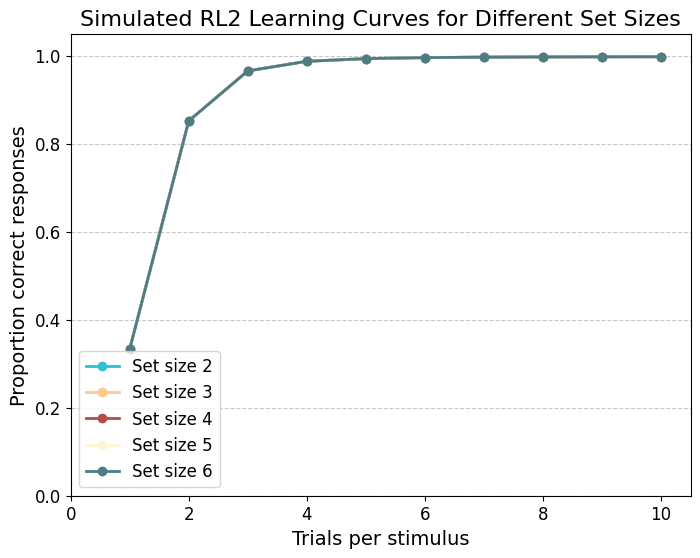

In [ ]:
import matplotlib.pyplot as plt
alpha = mle_estimate[0]
beta = mle_estimate[1]
print(f"Simulating RL2 learning curves with alpha={alpha:.4f}, beta={beta:.4f}")
print("Note: Standard RL2 model is independent of set size; curves should overlap.")

# --- Simulation Parameters ---
n_actions = 3       # Number of possible actions
n_trials = 10    # Max trials per stimulus (matches plot x-axis)
n_simulations = 2000 # Number of simulation runs to average over (for smoothness)
correct_action_index = 0 # Assume action 0 is the 'correct' one
initial_q_value = 0.0    # Starting Q-value for all actions

# Different set sizes to simulate (matches paper/image) [3]
set_sizes = [2, 3, 4, 5, 6]

# Dictionary to store average learning curves for each set size label
learning_curves = {}

# --- Run Simulation for each Set Size Label ---
# NOTE: The simulation logic *itself* does not depend on set_size for RL2
for set_size in set_sizes:
    print(f"  Simulating for set size label: {set_size}...")
    # Array to store the probability of choosing the correct action on each trial
    correct_choice_prob_history = np.zeros((n_simulations, n_trials))

    # Run multiple simulations for averaging
    for sim in range(n_simulations):
        # Initialize Q-values for this simulation run
        q_values = np.full(n_actions, initial_q_value, dtype=float)

        # Simulate trials for one stimulus
        for trial in range(n_trials):
            # --- Calculate Softmax probabilities ---
            logits = beta * q_values
            # Stable softmax
            scaled_logits = logits - np.max(logits)
            exp_logits = np.exp(scaled_logits)
            probabilities = exp_logits / np.sum(exp_logits)

            # Store the probability of choosing the correct action
            correct_choice_prob_history[sim, trial] = probabilities[correct_action_index]

            # --- Update Q-value (Simulate learning) ---
            # Assume the correct action is reinforced with reward=1
            reward = 1.0
            prediction_error = reward - q_values[correct_action_index]
            q_values[correct_action_index] += alpha * prediction_error

    # Average across simulations for this set size label
    learning_curves[set_size] = np.mean(correct_choice_prob_history, axis=0)

# --- Plotting ---
plt.figure(figsize=(8, 6)) # Adjust figure size if needed
trial_numbers = np.arange(1, n_trials + 1) # X-axis: Trials 1 to 10

# Define colors similar to the paper/image if desired
colors = {
    2: '#2EC0D4', # cyan
    3: '#FFC88C', # light orange
    4: '#B44C4C', # brown-red
    5: '#FFF4D4', # pale yellow / cream
    6: '#4C7C84'  # teal green-gray
}

for set_size in set_sizes:
    plt.plot(
        trial_numbers,
        learning_curves[set_size],
        label=f'Set size {set_size}',
        color=colors.get(set_size, None), # Use specific color if available
        marker='o', # Optional: add markers
        linewidth=2 # Optional: adjust line width
    )

# Style the plot
plt.xlabel('Trials per stimulus', fontsize=14)
plt.ylabel('Proportion correct responses', fontsize=14)
plt.title('Simulated RL2 Learning Curves for Different Set Sizes', fontsize=16)
plt.legend(fontsize=12)
plt.ylim(0, 1.05)
plt.xlim(0.5, n_trials + 0.5) # Adjust x-axis limits
plt.xticks(np.arange(0, n_trials + 1, 2), fontsize=12) # Ticks every 2 trials
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=12) # Y-ticks every 0.2
plt.grid(axis='y', linestyle='--', alpha=0.7) # Optional grid styling
plt.show()




#Subject Learning Plot

Calculating average learning data across all subjects...

Plotting average learning curves...


<ipython-input-53-60f2edfd1846>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['iterseq'] = df_clean['iterseq'].astype(int)


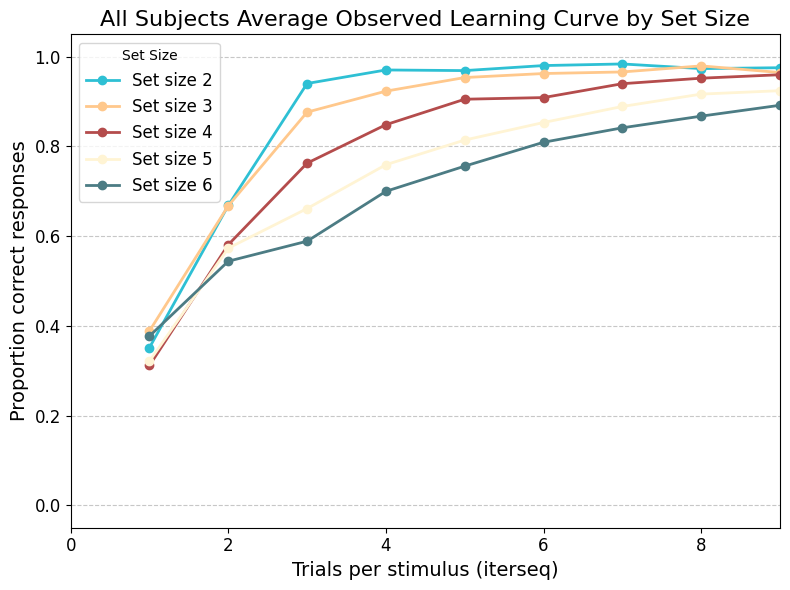

In [ ]:
df_clean['iterseq'] = df_clean['iterseq'].astype(int)
print("Calculating average learning data across all subjects...")
# Group by set size (ns) and stimulus iteration (iterseq) using the full cleaned dataframe
learning_data = df_clean.groupby(['ns', 'iterseq'])['cor'].mean()

# Unstack the data to have iterseq as index and ns as columns for easy plotting
learning_curves = learning_data.unstack(level='ns')

# Find the maximum iteration number from the averaged data
max_iter = 8
# trial_numbers not strictly needed if plotting using index, but can be useful
# trial_numbers = np.arange(1, max_iter + 1)

# --- Plotting ---
plt.figure(figsize=(8, 6))

# Define colors similar to the paper
colors = {
    2: '#2EC0D4', # cyan
    3: '#FFC88C', # light orange
    4: '#B44C4C', # brown-red
    5: '#FFF4D4', # pale yellow / cream - Adjusted for visibility
    6: '#4C7C84'  # teal green-gray
}
# Get unique set sizes present in the overall cleaned data
set_sizes_in_data = sorted(df_clean['ns'].unique())

print("\nPlotting average learning curves...")
for set_size in set_sizes_in_data:
    if set_size in learning_curves.columns:
        plt.plot(
            learning_curves.index, # Use the index (iterseq) from the unstacked data
            learning_curves[set_size],
            label=f'Set size {set_size}',
            color=colors.get(set_size, None), # Use specific color
            marker='o', # Keep markers to show data points
            linewidth=2,
            markersize=6
        )
    else:
        # This case shouldn't happen if set_sizes_in_data is derived from df_clean
        print(f"  No data found for set size {set_size} after averaging.")

# Style the plot
plt.xlabel('Trials per stimulus (iterseq)', fontsize=14)
plt.ylabel('Proportion correct responses', fontsize=14)
# Update title to reflect average across subjects
plt.title('All Subjects Average Observed Learning Curve by Set Size', fontsize=16)
plt.legend(fontsize=12, title="Set Size")
plt.ylim(-0.05, 1.05)
plt.xlim(0, max_iter + 1) # Adjust x-axis limit based on max observed iterseq
plt.xticks(np.arange(0, max_iter + 1, 2), fontsize=12)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#AIC Score

In [ ]:
def compute_log_likelihood(alpha_mle, beta_mle, stimuli, actions, rewards, S, A):
    """
    Computes the total log-likelihood of observed actions given MLE parameters.

    Args:
        alpha_mle (float): Maximum Likelihood Estimate for alpha.
        beta_mle (float): Maximum Likelihood Estimate for beta.
        stimuli (np.array): Array of stimulus indices (1-based).
        actions (np.array): Array of chosen action indices (1-based).
        rewards (np.array): Array of received rewards (0 or 1).
        S (int): Number of unique stimuli.
        A (int): Number of possible actions.

    Returns:
        float: Total log-likelihood, or -np.inf if invalid inputs found.
    """
    # Input validation
    if not (0 <= alpha_mle <= 1 and beta_mle >= 0):
         print(f"Warning: Invalid MLE params passed: alpha={alpha_mle}, beta={beta_mle}")
         return -np.inf
    if len(stimuli) != len(actions) or len(stimuli) != len(rewards):
        print("Warning: Data array lengths mismatch.")
        return -np.inf

    # Initialize Q-values (e.g., to zero)
    Q = np.zeros((S, A), dtype=float)
    total_log_likelihood = 0.0
    N = len(stimuli)

    for t in range(N):
        # Convert to 0-based index for numpy arrays
        s_idx = stimuli[t] - 1
        a_idx = actions[t] - 1

        # --- Check indices are valid ---
        if not (0 <= s_idx < S and 0 <= a_idx < A):
            print(f"Warning: Invalid stimulus ({stimuli[t]}) or action ({actions[t]}) index at trial {t}.")
            # Decide how to handle: return -inf, skip trial, etc.
            # Returning -inf is safest as it invalidates the likelihood
            return -np.inf

        # --- Calculate choice probabilities using MLE params ---
        logits = beta_mle * Q[s_idx]
        # Stable softmax
        max_logit = np.max(logits)
        exp_logits = np.exp(logits - max_logit)
        sum_exp_logits = np.sum(exp_logits)

        if sum_exp_logits <= 0 or not math.isfinite(sum_exp_logits):
             # Handle case where probabilities cannot be calculated (e.g., beta*Q is inf/nan)
             print(f"Warning: Unstable softmax calculation at trial {t} (beta={beta_mle}, Q={Q[s_idx]})")
             return -np.inf

        probs = exp_logits / sum_exp_logits

        # --- Get probability of the actually chosen action ---
        prob_chosen_action = probs[a_idx]

        # --- Add log probability to total (with protection) ---
        if prob_chosen_action <= 0 or not math.isfinite(prob_chosen_action):
            # If probability is zero or invalid, assign a very large negative log-likelihood
            # (or use a tiny floor like 1e-10 before log, though large negative is often better)
            log_prob_action = -np.inf # Effectively makes the total log-likelihood -inf
            print(f"Warning: Zero or invalid probability ({prob_chosen_action:.2g}) for chosen action at trial {t}.")
            # To avoid stopping entirely, you could use a floor:
            # log_prob_action = np.log(max(prob_chosen_action, 1e-10))
        else:
            log_prob_action = np.log(prob_chosen_action)

        total_log_likelihood += log_prob_action

        # --- Update Q-values using MLE alpha for next trial's calculation ---
        prediction_error = rewards[t] - Q[s_idx, a_idx]
        Q[s_idx, a_idx] += alpha_mle * prediction_error

        # Break early if log-likelihood becomes invalid
        if not math.isfinite(total_log_likelihood):
            print(f"Warning: Non-finite total log-likelihood encountered at trial {t}.")
            return -np.inf

    return total_log_likelihood

In [ ]:
subject_block_groups = df_clean.groupby(['subno', 'block'])
i=1
results_with_aic = [] # List to store results including AIC
for (subject, block), group_data in subject_block_groups:
        print(f"Processing Subject: {subject}, Block: {block}...")
        aic_value = np.nan # Default AIC to NaN
        log_lik = -np.inf  # Default log-likelihood
        # Prepare the actual data for this specific group from the input df
        stan_data = {
            'N': len(group_data),
            'S': int(group_data['ns'].max()),
            'A': 3, # Fixed number of actions
            'stimuli': group_data['stimseq'].values.astype(int),
            'actions': group_data['choice'].values.astype(int),
            'rewards': group_data['rew'].values.astype(int)
        }
        if mle_estimate is not None and not np.isnan(mle_estimate).any():
            alpha_mle = mle_estimate[0]
            beta_mle = mle_estimate[1]

            print(f"  Calculating log-likelihood for alpha={alpha_mle:.4f}, beta={beta_mle:.4f}...")
            log_lik = compute_log_likelihood(
                alpha_mle=alpha_mle,
                beta_mle=beta_mle,
                stimuli=stan_data['stimuli'],
                actions=stan_data['actions'],
                rewards=stan_data['rewards'],
                S=stan_data['S'],
                A=stan_data['A']
            )

            if math.isfinite(log_lik):
                k = 2 # Number of parameters (alpha, beta)
                aic_value = 2 * k - 2 * log_lik
                print(f"  Log-Likelihood: {log_lik:.4f}")
                print(f"  AIC: {aic_value:.4f}")
            else:
                print("  Log-Likelihood calculation failed (resulted in non-finite value). Cannot compute AIC.")
        else:
            print("  Skipping AIC calculation because MLE estimation failed or yielded NaN.")

        # Store results including AIC
        # Adjust this based on how you store results (e.g., appending to a list of dicts)
        results_with_aic.append({
            'subno': subject,
            'block': block,
            'alpha_mle': mle_estimate[0] if mle_estimate is not None else np.nan,
            'beta_mle': mle_estimate[1] if mle_estimate is not None else np.nan,
            'log_likelihood': log_lik if math.isfinite(log_lik) else np.nan,
            'aic': aic_value
        })
        i+=0
        if(i==19):
          break


df_results_aic = pd.DataFrame(results_with_aic)

Streaming output truncated to the last 5000 lines.
Processing Subject: 10, Block: 11...
  Calculating log-likelihood for alpha=0.3526, beta=6.9273...
  Log-Likelihood: -25.9238
  AIC: 55.8476
Processing Subject: 10, Block: 12...
  Calculating log-likelihood for alpha=0.3526, beta=6.9273...
  Log-Likelihood: -11.4418
  AIC: 26.8836
Processing Subject: 10, Block: 13...
  Calculating log-likelihood for alpha=0.3526, beta=6.9273...
  Log-Likelihood: -2.6522
  AIC: 9.3045
Processing Subject: 10, Block: 14...
  Calculating log-likelihood for alpha=0.3526, beta=6.9273...
  Log-Likelihood: -27.6685
  AIC: 59.3371
Processing Subject: 10, Block: 15...
  Calculating log-likelihood for alpha=0.3526, beta=6.9273...
  Log-Likelihood: -9.9189
  AIC: 23.8377
Processing Subject: 10, Block: 16...
  Calculating log-likelihood for alpha=0.3526, beta=6.9273...
  Log-Likelihood: -30.5236
  AIC: 65.0472
Processing Subject: 10, Block: 17...
  Calculating log-likelihood for alpha=0.3526, beta=6.9273...
  Log-L

In [ ]:
print(df_results_aic.mean())

subno             42.873418
block              9.500000
alpha_mle          0.352617
beta_mle           6.927303
log_likelihood   -20.881071
aic               45.762142
dtype: float64
